In [1]:
# Load packages
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))

suppressMessages(library(openair))
suppressMessages(library(BBmisc))
suppressMessages(library(caret))

In [2]:
suppressMessages(library(doMC))
registerDoMC(cores=as.integer(detectCores()*0.75))

In [3]:
suppressMessages(library(repr))
options(repr.plot.width=20,
        repr.plot.height=20,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [4]:
# Working directory
setwd("~/Repositories/AirQualityCOVID")

In [5]:
sites.lv <- c("es0118a")

## Load Data

In [6]:
load("data/data_AQ.rda")
load("data/meteorology.rda")

aq <- data_AQ %>%
        filter(site == "es0118a",
               date < ymd("2020-01-01")
              ) %>%
        timeAverage(avg.time = "day", type=c("site", "variable"))
aq$date <- as_date(aq$date)

mto <- data_Mto[data_Mto$site == "es0118a", ]

df <- merge(aq, mto,
              by = c("date", "site"), all.x=T) %>%
        drop_na() %>%
        select(-date_end, -process, -summary, -validity)

rm(data_AQ)
rm(data_Mto)
head(df)

,date,site,variable,value,ws,wd,atmos_pres,tmed,prec,tmin,tmax,presMax,presMin,RH,solar.radiation
,<date>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2013-01-01,es0118a,no,33.125000,0.8571429,225.2949,1022.433,6.4,0,3.4,9.4,945.9,940.2,80.65828,58.83178
2,2013-01-01,es0118a,pm10,8.833333,0.8571429,225.2949,1022.433,6.4,0,3.4,9.4,945.9,940.2,80.65828,58.83178
3,2013-01-01,es0118a,pm2.5,10.833333,0.8571429,225.2949,1022.433,6.4,0,3.4,9.4,945.9,940.2,80.65828,58.83178
4,2013-01-01,es0118a,no2,41.958333,0.8571429,225.2949,1022.433,6.4,0,3.4,9.4,945.9,940.2,80.65828,58.83178
5,2013-01-01,es0118a,o3,18.208333,0.8571429,225.2949,1022.433,6.4,0,3.4,9.4,945.9,940.2,80.65828,58.83178
6,2013-01-02,es0118a,no,101.000000,0.9321429,355.5002,1027.800,5.8,0,0.7,10.8,950.3,945.9,75.60469,71.71485


## Cross-Validation

In [7]:
leave.one.year.out <- function(yr, dat, omit.cl) { 
    # Do k-iteration of k-fold cv by pop yr data for test 
    #     and the rest for training
    # @params: omit.cl: columns to omit in the regression
    
    test <- which(year(dat$date) == yr)
    train <- which(year(dat$date) != yr)

    if(length(test) == 0) {
        return()
    } 
    if (length(train) == 0) {
        return()
    }
    
    model <- train(value ~., 
                   data=dat[, -omit.cl], subset=train,
                   method="glm", family=Gamma()
                  )

    y.th <- predict(model, newdata=dat[test, -omit.cl])
    
    data.frame(times = dat[test, ]$date,
               test.pred = y.th,
               test.obs = dat[test,]$value
              )  
}

In [8]:
years <- 2013:2019

no.num.cl <- 1:3 # no numeric columns 
data.df <- data.frame()

# Create one model for each pair of station-pollutant
for (st in sites.lv) {
    data.st <- df[df$site == st,]
    
    for (pll in levels(as.factor(data.st$variable))) {
        dats <- data.st %>%
                filter(variable == pll) %>%
                filter(value < max(value)) %>%
                filter(value < max(value)) %>%
                filter(value < max(value)) %>%
                normalize(method = "range", 
                          range = c(1, 2), margin = 1) %>% 
                drop_na()
        
        model.df <- do.call(rbind, lapply(years, leave.one.year.out,
                                        dats, no.num.cl))

        data.df <- rbind(data.df,
                       cbind(data.frame("variable"=rep(pll, nrow(model.df)),
                                        "site"=rep(st, nrow(model.df)),
                             model.df))
                       )
    }
}
data.df$year <- as.factor(year(data.df$times))

In [9]:
head(data.df)

,variable,site,times,test.pred,test.obs,year
,<chr>,<chr>,<date>,<dbl>,<dbl>,<fct>
1,no,es0118a,2013-01-01,1.270827,1.138123,2013
2,no,es0118a,2013-01-02,1.389013,1.429953,2013
3,no,es0118a,2013-01-03,1.280208,1.324077,2013
4,no,es0118a,2013-01-05,1.405296,1.752956,2013
5,no,es0118a,2013-01-06,1.341747,1.475636,2013
6,no,es0118a,2013-01-07,1.308643,1.162666,2013


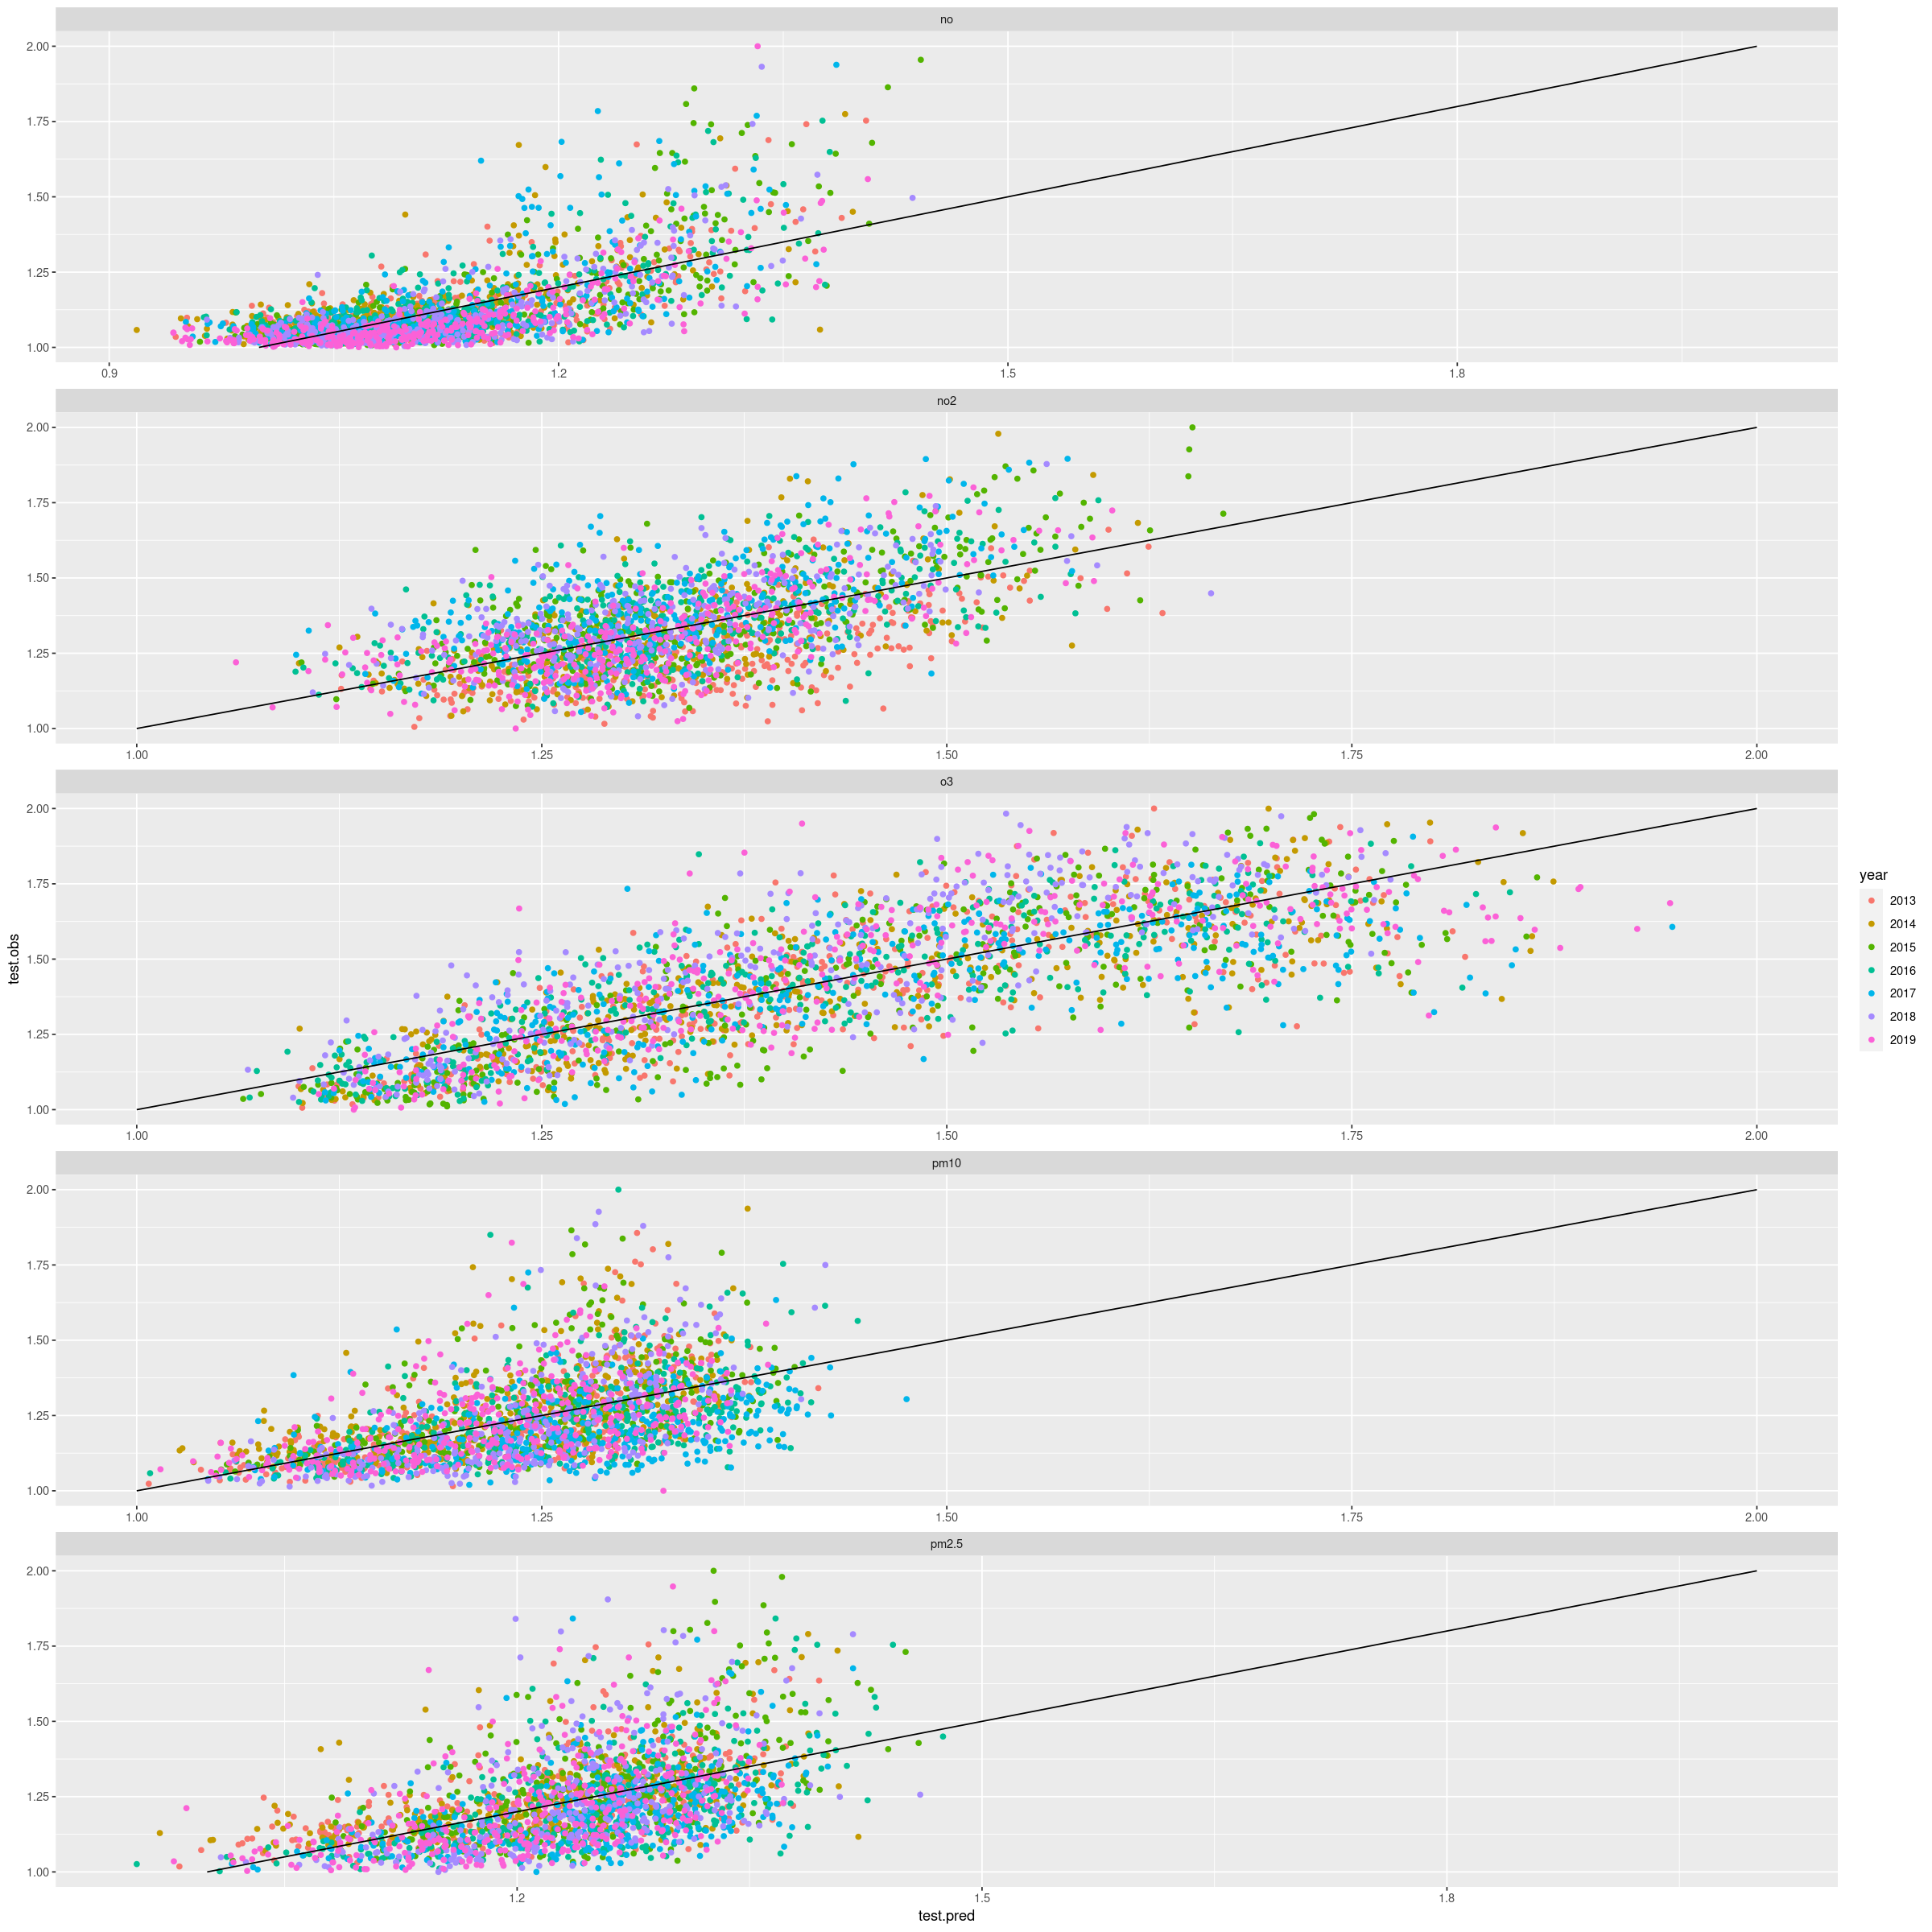

In [10]:
ggplot(data=data.df) +
    geom_point(aes(x=test.pred, y=test.obs, color = year)) +
    geom_line(aes(x=test.obs, y=test.obs), color = "black") +
    facet_wrap(~variable, scale="free", ncol=1)

In [11]:
#```R
ggsave(plot = last_plot(), 
       filename = "glm-scatter.png",
       device = "png", 
       path = "plots/cross-validation/glm/",
       width = 15,
       height = 15,
      )
#```

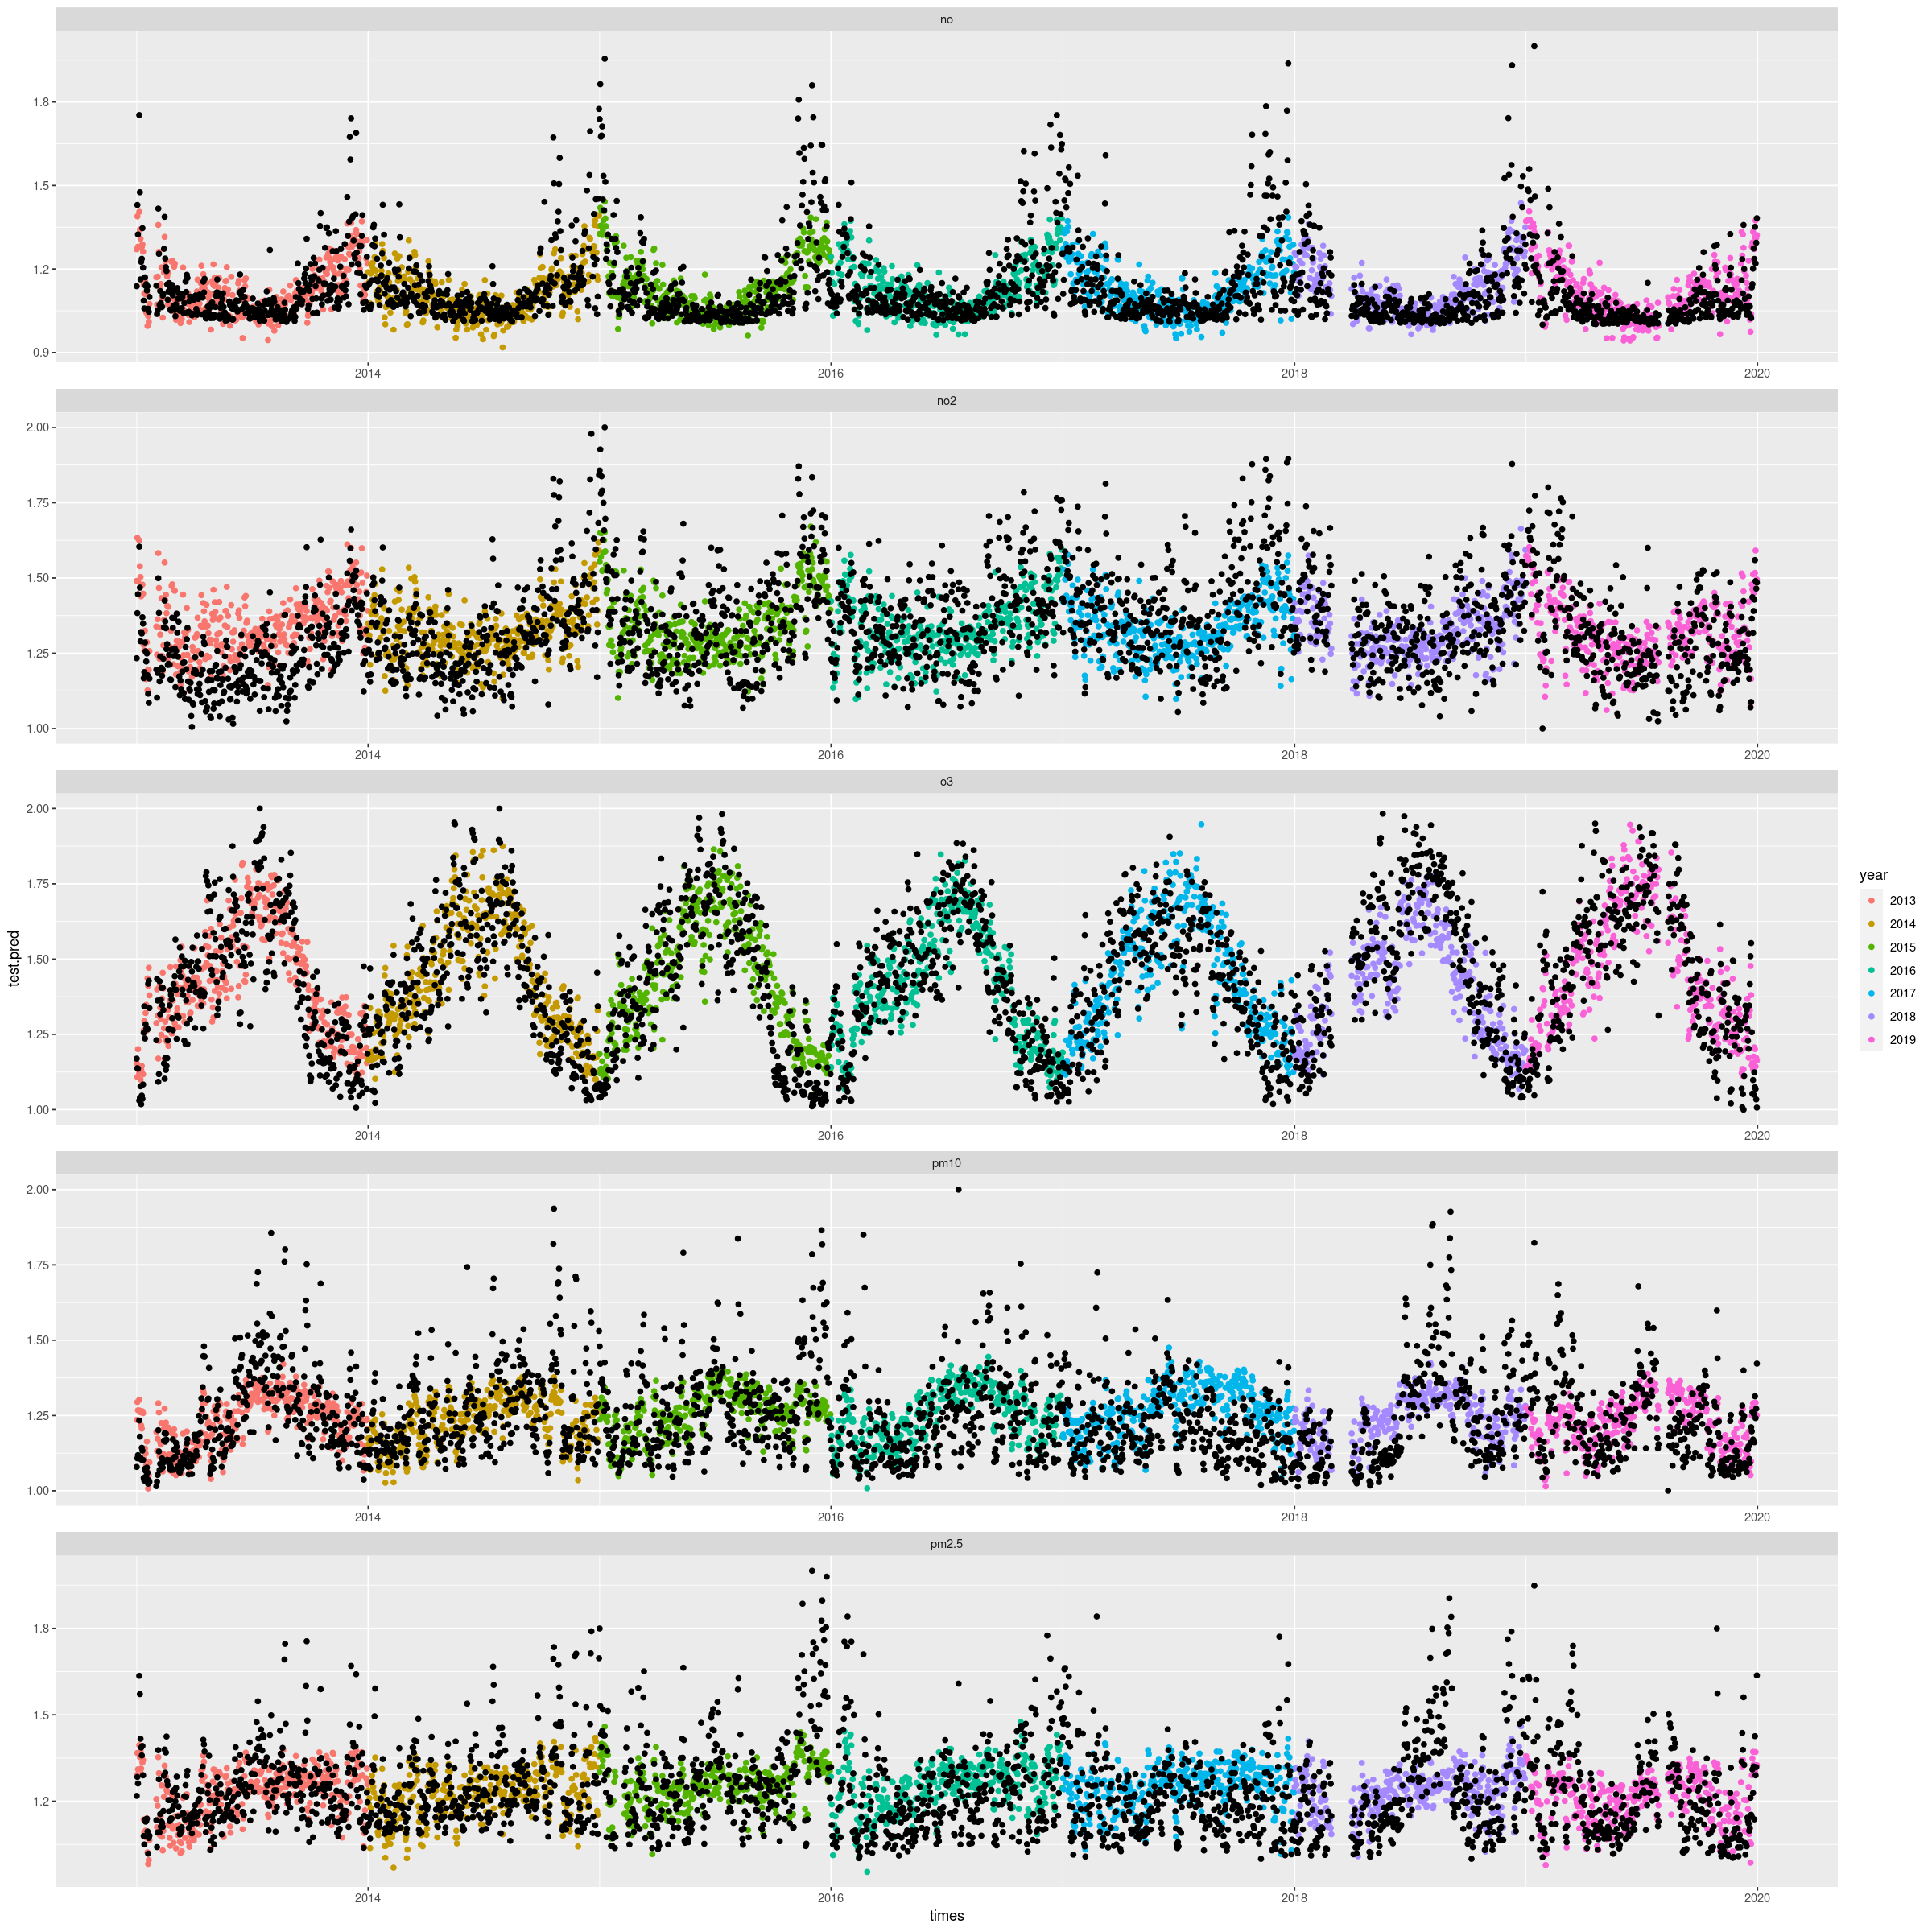

In [12]:
ggplot(data=data.df) +
    geom_point(aes(x=times, y=test.pred, color = year)) +
    geom_point(aes(x=times, y=test.obs), color = "black") +
    facet_wrap(~variable, scale="free", ncol=1)

In [13]:
#```R
ggsave(plot = last_plot(), 
       filename = "glm-timeSerie.png",
       device = "png", 
       path = "plots/cross-validation/glm/",
       width = 15,
       height = 15,
      )
#```